## 필요한 모듈 설치

In [ ]:
!apt install libomp-dev
!pip install pytorch-metric-learning
!pip install mkl
!pip install faiss
!pip install faiss-gpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 0s (493 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Se

In [ ]:
!wget  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!wget  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/

--2022-06-06 06:17:13--  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9cc393ec612061f033a/5ac54beae586bb11ec0ace46?response-content-disposition=attachment%3B%20filename%3D%22faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20220606T061713Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjELv%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJIMEYCIQD99edKI04lt0PiszbHXBR7fZ92av%2FoGo%2BzzCR7lfG39QIhAOZhW18Tw5q%2FgwNcTAG5FXh29mxtjjA3jr%2BJ4isoaBwrKtsECLT%2F%2F%2F%2F%2F%

## 사용할 모듈들 import

In [ ]:
import faiss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

## 학습과 테스트에 이용할 함수 정의

In [ ]:
def train(model, loss_func, device, train_loader, loss_optimizer, epoch) :
  model.train()
  for batch_idx, (data, labels) in enumerate(train_loader) :
    data, labels = data.to(device), labels.to(device)

    loss_optimizer.zero_grad()
    embeddings = model(data)
    loss = loss_func(embeddings, labels)
    loss.backward()
    loss_optimizer.step()

    if batch_idx % 100 == 0 :
      print("Epoch {} Iteration {} : Loss = {}".format(epoch, batch_idx, loss))

def get_all_embeddings(dataset, model) :
  tester = testers.BaseTester()
  return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator) :
  train_embeddings, train_labels = get_all_embeddings(train_set, model)
  test_embeddings, test_labels = get_all_embeddings(test_set, model)
  train_labels = train_labels.squeeze(1)
  test_labels = test_labels.squeeze(1)

  print("Computing accuracy")
  accuracies = accuracy_calculator.get_accuracy(test_embeddings, train_embeddings, test_labels, train_labels, False)
  print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

## 사용할 데이터 불러옴

In [ ]:
device = torch.device("cuda")

img_mean, img_std = (0.1307,), (0.3081,)
normalize = transforms.Normalize(img_mean, img_std)
transform = transforms.Compose([transforms.ToTensor(), normalize])

batch_size = 128
train_epoch = 15

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset2, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## 딥러닝에 이용할 모델 정의

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2))

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(3 * 3 * 128, 256, bias=True),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1))

        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(256, 64, bias=True),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU())

        self.fc3 = torch.nn.Linear(64, 16, bias=True)

        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

## 모델을 불러오고 사용할 Loss를 설정함

In [ ]:
model = CNN().to(device)
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=16)
loss_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

## 실제로 학습과 테스트를 하고 정확도 출력

In [ ]:
for epoch in range(1, train_epoch + 1) :
    train(model, loss_func, device, train_loader, loss_optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

Epoch 1 Iteration 0 : Loss = 48.46612548828125
Epoch 1 Iteration 100 : Loss = 1.7121238708496094
Epoch 1 Iteration 200 : Loss = 2.366046667098999
Epoch 1 Iteration 300 : Loss = 1.6060259342193604
Epoch 1 Iteration 400 : Loss = 0.4166394770145416


100%|██████████| 313/313 [00:02<00:00, 122.45it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9888
Epoch 2 Iteration 0 : Loss = 0.7334944009780884
Epoch 2 Iteration 100 : Loss = 1.5025959014892578
Epoch 2 Iteration 200 : Loss = 0.5814049243927002
Epoch 2 Iteration 300 : Loss = 1.4601352214813232
Epoch 2 Iteration 400 : Loss = 0.32106396555900574


100%|██████████| 313/313 [00:02<00:00, 125.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9906
Epoch 3 Iteration 0 : Loss = 0.8306301236152649
Epoch 3 Iteration 100 : Loss = 0.250081330537796
Epoch 3 Iteration 200 : Loss = 0.8983888626098633
Epoch 3 Iteration 300 : Loss = 0.2680583894252777
Epoch 3 Iteration 400 : Loss = 0.7999280691146851


100%|██████████| 313/313 [00:02<00:00, 123.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9916
Epoch 4 Iteration 0 : Loss = 0.09596732258796692
Epoch 4 Iteration 100 : Loss = 0.8153188228607178
Epoch 4 Iteration 200 : Loss = 0.2921009659767151
Epoch 4 Iteration 300 : Loss = 0.07483085244894028
Epoch 4 Iteration 400 : Loss = 0.39574846625328064


100%|██████████| 313/313 [00:02<00:00, 124.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9924000000000001
Epoch 5 Iteration 0 : Loss = 1.1606831550598145
Epoch 5 Iteration 100 : Loss = 1.7284550267504528e-05
Epoch 5 Iteration 200 : Loss = 1.0331261364626698e-05
Epoch 5 Iteration 300 : Loss = 0.6509388089179993
Epoch 5 Iteration 400 : Loss = 0.8227031826972961


100%|██████████| 313/313 [00:02<00:00, 121.83it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9936
Epoch 6 Iteration 0 : Loss = 1.3343324098968878e-05
Epoch 6 Iteration 100 : Loss = 1.2179908752441406
Epoch 6 Iteration 200 : Loss = 0.4232688248157501
Epoch 6 Iteration 300 : Loss = 0.8218798637390137
Epoch 6 Iteration 400 : Loss = 0.000991901382803917


100%|██████████| 313/313 [00:02<00:00, 111.25it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9923000000000001
Epoch 7 Iteration 0 : Loss = 0.6404356956481934
Epoch 7 Iteration 100 : Loss = 0.981894850730896
Epoch 7 Iteration 200 : Loss = 0.006922493223100901
Epoch 7 Iteration 300 : Loss = 0.008973173797130585
Epoch 7 Iteration 400 : Loss = 0.07010139524936676


100%|██████████| 313/313 [00:02<00:00, 119.58it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9935
Epoch 8 Iteration 0 : Loss = 0.202133908867836
Epoch 8 Iteration 100 : Loss = 0.42054733633995056
Epoch 8 Iteration 200 : Loss = 0.2249886393547058
Epoch 8 Iteration 300 : Loss = 0.0011875861091539264
Epoch 8 Iteration 400 : Loss = 0.06939683109521866


100%|██████████| 313/313 [00:02<00:00, 123.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9935
Epoch 9 Iteration 0 : Loss = 0.10668929666280746
Epoch 9 Iteration 100 : Loss = 0.11922955513000488
Epoch 9 Iteration 200 : Loss = 3.862263110931963e-05
Epoch 9 Iteration 300 : Loss = 0.026047809049487114
Epoch 9 Iteration 400 : Loss = 1.0225558071397245e-06


100%|██████████| 313/313 [00:02<00:00, 125.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.994
Epoch 10 Iteration 0 : Loss = 9.489936587669945e-07
Epoch 10 Iteration 100 : Loss = 0.0018407185561954975
Epoch 10 Iteration 200 : Loss = 0.11747898161411285
Epoch 10 Iteration 300 : Loss = 0.1375563144683838
Epoch 10 Iteration 400 : Loss = 0.005892707500606775


100%|██████████| 313/313 [00:02<00:00, 124.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9922000000000001
Epoch 11 Iteration 0 : Loss = 0.2890961766242981
Epoch 11 Iteration 100 : Loss = 0.5513922572135925
Epoch 11 Iteration 200 : Loss = 0.17355427145957947
Epoch 11 Iteration 300 : Loss = 0.35825809836387634
Epoch 11 Iteration 400 : Loss = 0.0007725344621576369


100%|██████████| 313/313 [00:02<00:00, 127.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9931000000000001
Epoch 12 Iteration 0 : Loss = 0.009549182839691639
Epoch 12 Iteration 100 : Loss = 0.18121179938316345
Epoch 12 Iteration 200 : Loss = 3.3806787769208313e-07
Epoch 12 Iteration 300 : Loss = 5.0537702918518335e-05
Epoch 12 Iteration 400 : Loss = 0.0009844403248280287


100%|██████████| 313/313 [00:02<00:00, 125.58it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9943000000000001
Epoch 13 Iteration 0 : Loss = 0.17579106986522675
Epoch 13 Iteration 100 : Loss = 0.037088699638843536
Epoch 13 Iteration 200 : Loss = 0.0055670663714408875
Epoch 13 Iteration 300 : Loss = 0.32239025831222534
Epoch 13 Iteration 400 : Loss = 6.652210868196562e-05


100%|██████████| 313/313 [00:02<00:00, 127.85it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9939
Epoch 14 Iteration 0 : Loss = 2.6042474928544834e-05
Epoch 14 Iteration 100 : Loss = 0.27115392684936523
Epoch 14 Iteration 200 : Loss = 6.612386016513483e-08
Epoch 14 Iteration 300 : Loss = 0.19524012506008148
Epoch 14 Iteration 400 : Loss = 0.07729543000459671


100%|██████████| 313/313 [00:02<00:00, 125.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9939
Epoch 15 Iteration 0 : Loss = 8.102155106826103e-07
Epoch 15 Iteration 100 : Loss = 0.00829196535050869
Epoch 15 Iteration 200 : Loss = 0.14984846115112305
Epoch 15 Iteration 300 : Loss = 2.554215370764723e-06
Epoch 15 Iteration 400 : Loss = 1.7136316898813675e-07


100%|██████████| 313/313 [00:02<00:00, 125.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.9946


## outlier를 출력하고 시각화

In [ ]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)

100%|██████████| 1875/1875 [00:15<00:00, 121.66it/s]


In [ ]:
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1))
print(f"There are {len(outliers)} outliers")

There are 18 outliers


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [ ]:
inv_normalize = transforms.Normalize(mean=[-m/s for m, s in zip(img_mean, img_std)], std=[1/s for s in img_std])

def imshow(img, figsize=(8, 4)) :
  img = inv_normalize(img)
  npimg = img.numpy()
  plt.figure(figsize=figsize)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def imshow_many(dataset, outliers, n=32) :
  imgs = [
          dataset[outliers[i]][0]
          for i in np.random.choice(
              len(outliers), size=min(n, len(outliers)), replace=False
          )
  ]
  imshow(torchvision.utils.make_grid(imgs))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


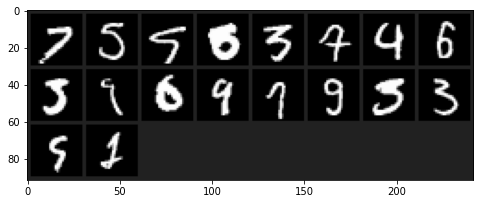

In [ ]:
imshow_many(dataset1, outliers)